<link rel="shortcut icon" href="../assets/favicon.ico">

##  <a href="../index.html#relaciones_interprovinciales_en_espanha" style="color:grey;text-decoration: none"> &lt; &lt; Volver al Índice

----------------------------
<div style="text-align:center"><span style="color:green; font-family:Georgia; font-size:3em;"><u>Relaciones Interprovinciales en España</u></span></div>
    
--------------------------------------------

<div align="left"><a href="https://github.com/braisseara/blog"> <span style="color:green; font-family:Georgia; font-size:1em;"><u>Brais Seara Martínez @ github.com/braisseara/blog </u></span></a></div>

En esta entrada analizamos los datos de la **Estadística de Nacimientos** que elabora cada año el Instituto Nacional de Estadística (INE), prestando especial atención a las provincias de origen de los padres de los nacidos.

<a name="setup"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[I] Setup</span></div>

En este apartado cargamos todos los datos que vamos a usar 

# Descarga de los Ficheros de Nacimientos

Descargamos los ficheros de Nacimientos correspondientes a los años que queremos analizar, en la siguiente dirección del INE:

http://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736177007&menu=resultados&secc=1254736195443&idp=1254735573002

Solamente nos descargamos los ficheros posteriores a 2007, porque los de años anteriores involucran metodologías heterogéneas.

En nuestro directorio de trabajo los almacenamos en la carpeta **../../datos/relaciones_interprovinciales_en_espanha**, separando por un lado los ficheros de **microdatos** propios de cada año, de los **metadatos** que vienen con cada uno de ellos, y que son iguales para todos. 

Tenemos además otra carpeta con todos los metadatos que hemos traído de otras fuentes, ubicada en **externos**

### Estructura de Carpetas de Datos

In [3]:
#../../datos/relaciones_interprovinciales_en_espanha
#    microdatos
#        2007.txt
#        2011.txt
#        2014.txt
#        2017.txt
#    metadatos
#        Diseñoanonimizadonacimientos.xls
#        Valores válidosDiseñoanonimizadonacimientos.xls
#        externos
#            metadatos_provincias.txt
#            pip_pc_provincia.txt
#            pip_pp_ccaa.txt
#    mapa

# Imports

In [65]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import geopandas as gpd
import math
from collections import Counter
# + tener mapclassify instalado

# Config

In [89]:
colormap = "OrRd" #"Reds" #"seismic"

# Metadatos

### INE.Nacimientos

El INE nos proporciona 2 ficheros excel de metadatos para los Nacimientos a partir del 2007:
* *Diseñoanonimizadonacimientos.xls*

* *Valores válidosDiseñoanonimizadonacimientos.xls*

Lo único que ahora nos interesa de ellos son 3 columnas del primero, que nos indican la Longitud fija que ocupan los registros de cada columna de microdatos, sus Nombres, y la Descripción de lo que representan.

In [5]:
ruta_datos = "../../datos/relaciones_interprovinciales_en_espanha/"

In [6]:
metadatos_ine = pandas.read_excel(ruta_datos + "metadatos/Diseñoanonimizadonacimientos.xls", 0)
metadatos_ine = metadatos_ine[['Longitud','Nombre','Descripción']]

In [7]:
metadatos_ine.head()

,Longitud,Nombre,Descripción
0,2,PROI,PROVINCIA DE INSCRIPCIÓN
1,3,MUNI,MUNICIPIO DE INSCRIPCIÓN
2,2,MESPAR,MES DEL PARTO
3,4,ANOPAR,AÑO DEL PARTO
4,2,PROPAR,PROVINCIA DEL PARTO


### Externos

Los metadatos que nos proporciona el INE en los mismos ficheros de Nacimientos son insuficientes, ya que las provincias están representadas según un código numérico, por lo que necesitamos un mapping que nos dé los nombres reales de las provincias. El mapping lo podemos encontrar aquí:

https://www.ine.es/daco/daco42/codmun/cod_provincia.htm

Además, también nos interesa otra información sobre las provincias con el fin de poder agruparlas u ordenarlas de algún modo significativo.

En el archivo  **/despues_2007/metadatos/externos/metadatos_provincias.txt** adjuntamos la CCAA autónoma, y también los gentilicios masculino y femenino.

A partir de las estadísticas económicas del INE, obtenemos el PIB per Cápita de cada provincia y de cada Comunidad Autónoma

https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736167628&menu=resultados&idp=1254735576581

que guardamos en los ficheros **/despues_2007/metadatos/externos/pip_pc_provincia.txt** y         **/despues_2007/metadatos/externos/pip_pc_ccaa.txt**

In [8]:
metadatos_provincias = pandas.read_csv(ruta_datos + "metadatos/externos/metadatos_provincias.txt", '\t', encoding = 'iso8859_3')

pip_pc_provincia = pandas.read_csv(ruta_datos + "metadatos/externos/pip_pc_provincia.txt", '\t', encoding = 'iso8859_3')
pip_pp_ccaa = pandas.read_csv(ruta_datos + "metadatos/externos/pip_pp_ccaa.txt", '\t', encoding = 'iso8859_3')

metadatos_provincias = metadatos_provincias.join(pip_pc_provincia.set_index('Provincia'), how = 'left', on = 'Provincia')
metadatos_provincias = metadatos_provincias.join(pip_pp_ccaa.set_index('CCAA'), on = 'CCAA', how = 'left')

metadatos_provincias.set_index('Provincia').sort_values('pip_pc', ascending = False).head()

,Código,CCAA,gen_mas,gen_fem,nortesur,pip_pc,pop,pip_pc_ccaa
Provincia,,,,,,,,
Araba,1,País Vasco,alavés,alavesa,8,36066,323,32969
Madrid,28,Madrid,madrileño,madrileña,28,32857,6446,33824
Gipuzcoa,20,País Vasco,guipuzcoano,guipuzcoana,6,31486,708,32969
Bizkaia,48,País Vasco,bizcaíno,bizcaína,5,30378,1134,32969
Navarra,31,Navarra,navarro,navarra,9,29859,638,30853


Creamos diccionarios que nos permitan acceder a algunos de estos metadatos facilmente:

In [9]:
dict_cod_prov  = {provincia[1]: provincia[2] for provincia in metadatos_provincias.itertuples()}
dict_prov_ccaa = {provincia[2]: provincia[3] for provincia in metadatos_provincias.itertuples()}
dict_gen_mas   = {provincia[2]: provincia[4] for provincia in metadatos_provincias.itertuples()}
dict_gen_fem   = {provincia[2]: provincia[5] for provincia in metadatos_provincias.itertuples()}

# Mapa

Cargamos el mapa de España en formato *shape* que usaremos más adelante

In [ ]:
map_df = gpd.read_file(ruta_datos + "shape_map_spain/Provincias_ETRS89_30N.shp")
map_df.index = map_df["Texto_Alt"]

# Provincias Agrupadas y Ordenadas

Con estos datos podemos crear una lista ordenada de Provincias, agrupadas por CCAA, ordenadas las CCAA por PIB per Cápita, y ordenadas también por PIB per Cápita las provincia dentro de su CCAA:

In [10]:
provincias_ordenadas = metadatos_provincias.sort_values(['pip_pc_ccaa','pip_pc'], ascending = False)['Provincia']
#provincias_ordenadas = metadatos_provincias.sort_values(['nortesur'], ascending = True)['Provincia']

provincias_ordenadas[0:10]

27       Madrid
7         Araba
5      Gipuzcoa
4       Bizkaia
8       Navarra
22    Tarragona
21    Barcelona
15       Girona
20       Lleida
13       Huesca
Name: Provincia, dtype: object

In [11]:
dict_provincias_ordenadas = {provincia[2]: provincia[0] for provincia in provincias_ordenadas.reset_index().itertuples()}

provincia_Muestra = "Barcelona"
print(provincia_Muestra + ' va de ' + str(dict_provincias_ordenadas[provincia_Muestra]+1) + 'ª')

Barcelona va de 7ª


# Lectura Microdatos

In [12]:
años = [2017]

ruta_microdatos = ruta_datos + "microdatos/"

if not "DFs_" in vars():
    DFs_ = {}
DFs  = {}
for año in años:  
    try:
        DFs[año] = DFs_[año].copy()
    except KeyError:
        DFs_[año] = pandas.read_fwf(ruta_microdatos + str(año) + ".txt", widths= metadatos_ine['Longitud'])
        DFs[año] = DFs_[año].copy()

In [13]:
for key in list(DFs.keys()):
    # nombramos columnas
    DFs[key].columns = metadatos_ine['Nombre']
    # nos quedamos con las columnas que nos interesan
    DFs[key] =  DFs[key][['PROMA','PROPA','PROI']]  # prov. nacimiento madre, prov. nacimiento padre y prov. nacimiento niñ@
    # eliminamos filas con valores nulos
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROI'])]
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROMA'])]
    DFs[key] =  DFs[key][np.isfinite( DFs[key]['PROPA'])]
    # eliminamos filas correspondientes a padres y madres nacidos en el extranjero
    DFs[key] =  DFs[key][DFs[key]['PROMA'] != 99]      
    DFs[key] =  DFs[key][DFs[key]['PROPA'] != 99]
    # substituímos los códigos de las provincias por sus nombres 
    DFs[key] = DFs[key].replace({'PROI':dict_cod_prov})
    DFs[key] = DFs[key].replace({'PROMA':dict_cod_prov})
    DFs[key] = DFs[key].replace({'PROPA':dict_cod_prov})

In [14]:
DFs[año].head().reset_index(drop = True)

Nombre,PROMA,PROPA,PROI
0,Madrid,A Coruña,A Coruña
1,Madrid,León,Madrid
2,Madrid,Madrid,Madrid
3,Barcelona,Barcelona,Barcelona
4,Barcelona,Barcelona,Barcelona


In [15]:
print(' Toda la información que contienen nuestros DataSets es tipo: \n')

for row in DFs[año].head().reset_index(drop = True).itertuples():
    print(str(row[0] + 1) + '- una ' + dict_gen_fem[row[1]] + " y un " + dict_gen_mas[row[2]] + " son padres en " + row[3])
print ('...\n\n' + '(' + str(DFs[año].shape[0]) + ' nacimientos en total, año ' + str(año) + ')')

 Toda la información que contienen nuestros DataSets es tipo: 

1- una madrileña y un coruñés son padres en A Coruña
2- una madrileña y un leonés son padres en Madrid
3- una madrileña y un madrileño son padres en Madrid
4- una barcelonesa y un barcelonés son padres en Barcelona
5- una barcelonesa y un barcelonés son padres en Barcelona
...

(269178 nacimientos en total, año 2017)


<a name="conteo"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[II] Conteo Nacidos por Provincia de Origen de los Padres</span></div>

A continuación, procedemos a elaborar una matriz que recoja el número de nacidos para cada combinación de origines provinciales de los padres

In [17]:
matrices = {}

for key in list(DFs.keys()):
    
    # crear matriz de ceros
    matrices[key] = []
    for i in range(0,len(provincias_ordenadas)):
        matrices[key].append([])
        for j in range(0,len(provincias_ordenadas)):
            matrices[key][i].append(0)
            
    # rellenar matriz
    for nac in DFs[key].itertuples():
        try:
            matrices[key][dict_provincias_ordenadas[nac[1]]][dict_provincias_ordenadas[nac[2]]] += 1
        except KeyError:
            continue
            
    # etiquetar matriz
    matrices[key] = pandas.DataFrame(matrices[key])
    matrices[key].columns= provincias_ordenadas
    matrices[key].index = provincias_ordenadas

In [18]:
def restringir_matriz (matriz, minimo_hijos):
    booleanos = list((matriz.sum(1) + matriz.sum(0))/2 > minimo_hijos)
    provincias_significativas = pandas.Series(list(matriz.index)).loc[booleanos]
    return(matriz.loc[provincias_significativas, provincias_significativas])

In [19]:
for key in list(DFs.keys()):      
    # restringir matriz
    matrices[key] = restringir_matriz(matrices[key], 0)

Dado que existen grandes diferencias en el número de nacidos con cada combinación de provincias de los padres, al haber provincias con poblaciones mucho mayores que otras, podemos considerar aplicar a las matrices creadas una función de suavizado logarítmico

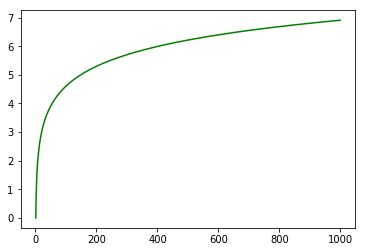

In [20]:
a = np.arange(1,1000,1)
b = [math.log(i) for i in a ]
plt.plot(a, b, color = "g")

Ilustración del efecto suavizador que produce la función logarítmica

### Función de representación gráfica de matrices:
(con opción de suavizado logarítmico)

In [21]:
def plot_matriz(matriz, titulo = 'Matriz', suavizado_logaritmico = False, times_sl = 1, anular_diagonal = False):
    matriz = matriz.copy()
    provincias = list(matriz.index)
    n = len(provincias)
    if anular_diagonal == True:
        for i in range(0,n):
            matriz.iloc[i,i] = min(matriz.min())
    if suavizado_logaritmico == True:
        for time in range(0,times_sl):
            matriz = matriz.applymap(lambda celda : math.log(max(0,celda) + 1) )
    fig, ax = plt.subplots(1, figsize=(13, 13))
    plt.imshow(matriz, cmap = colormap, aspect='auto')
    ax.set_yticks(np.arange(n))
    ax.set_yticklabels(provincias)
    ax.set_xticks(np.arange(n))
    ax.set_xticklabels(provincias, rotation=70)
    ax.set_title(titulo, fontdict = {'fontsize': 30,'fontweight':500}, pad =30)
    ax.set_xlabel('padre',fontweight='bold',fontsize=20, labelpad = 10)
    ax.set_ylabel('madre',fontweight='bold',fontsize=20, labelpad = 10)

    ps = pandas.Series(provincias).reset_index()
    ps.columns = ['i', 'Provincia']
    ccaa_n = ps.join(metadatos_provincias.set_index('Provincia'), how = 'left', on = 'Provincia')['CCAA']
    ccaa_n = list(pandas.DataFrame.from_dict(Counter(ccaa_n), orient='index').iloc[:,0].cumsum().apply(lambda i: i-0.5))

    ax.set_yticks(ccaa_n, minor = True)
    ax.set_xticks(ccaa_n, minor = True)
    ax.grid(which='minor', alpha=1, linewidth = 1.2, linestyle=':', color = 'black')

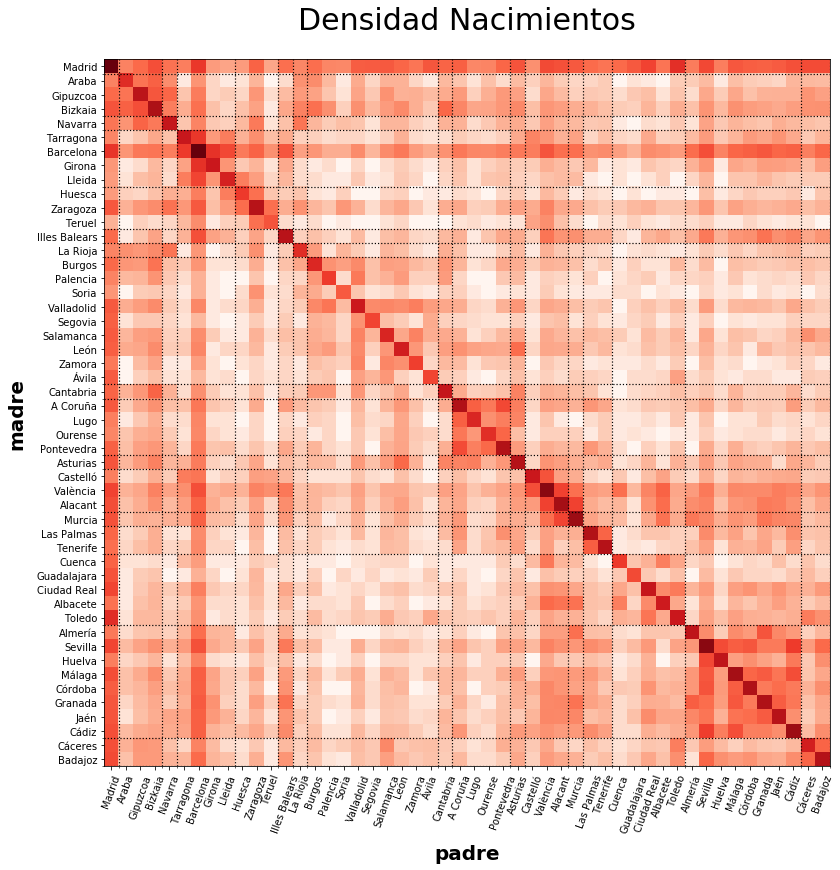

In [22]:
plot_matriz(matrices[año], "Densidad Nacimientos", True)

En este gráfico suavizado, donde agrupamos las provincias por CCAA, podemos visualizar la mayor frecuencia de nacidos de padres procedentes de la misma provincia (línea oscura diagonal), y también de nacidos con padres procedentes de la misma Comunidad Autónoma (cuadrados rodeados de lineas discontinuas centrados en la diagonal). Asímismo, podemos ver que los procedentes de las provincias de Madrid y Barcelona engendran una cantidad no despreciable de hijos con personas procedents de prácticamente cualquier otra de las provincias de España

Vamos a crear una función para obtener facilmente las primeras (o ultimas) posiciones del ranking en matrices de este tipo

### Función de Rankings:

In [23]:
def top_matriz(matriz, top = 10, que = 'max', x = 'values', madres=None, padres=None, funcion_values = lambda x : round(x, 2)):
    madre = []
    padre = []
    values = []
    if madres == None:
        madres = list(matriz.columns)
    else:
        if isinstance(madres, str):
            madres = [madres]
    if padres == None:
        padres = list(matriz.columns)
    else:
        if isinstance(padres, str):
            padres = [padres]
    for i in madres:
        for j in padres:
            madre.append(i) 
            padre.append(j) 
            values.append(matriz.loc[i,j])
    df = pandas.DataFrame({'madre': madre, 'padre': padre, x: values}).sort_values([x], ascending = (que == 'min') )
    df.index = [str(i + 1) + 'º' for i in df.reset_index().index]
    if isinstance(funcion_values, str):
        if funcion_values == 'delta%':
            funcion_values = lambda x : '+ ' + str(round((x-1)*100,2)) + ' %'
        elif funcion_values == 'delta':
            funcion_values = lambda x : '+ ' + str(round(x,2))
        elif funcion_values == '%':
            funcion_values = lambda x : str(round(x*100,2)) + ' %'
    df[x] = df[x].apply(funcion_values)
    return(df.head(top))

In [24]:
top_matriz(matrices[año], x = 'nacimientos')

,madre,padre,nacimientos
1º,Madrid,Madrid,23762
2º,Barcelona,Barcelona,23717
3º,València,València,11562
4º,Sevilla,Sevilla,11532
5º,Murcia,Murcia,7689
6º,Cádiz,Cádiz,7618
7º,Málaga,Málaga,6669
8º,Alacant,Alacant,6522
9º,Bizkaia,Bizkaia,5026
10º,Córdoba,Córdoba,4562


<a name="sexos"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[III] Vizcaína con Zaragozano, y Viceversa </span></div>

En este apartado estudiamos la posibilidad de que, por ejemplo, existan más Vizcaínas teniendo hijos con Zaragozanos que Vizcaínos teniendo hijos con Zaragozanas

In [102]:
matriz_sexo_diferencial = matrices[año].copy()
n = matrices[año].shape[0]
umbral = n/2
for i in range(0,n):
    for j in range(0,n):
        matriz_sexo_diferencial.iloc[i,j] =  matrices[año].iloc[j,i] - matrices[año].iloc[i,j]

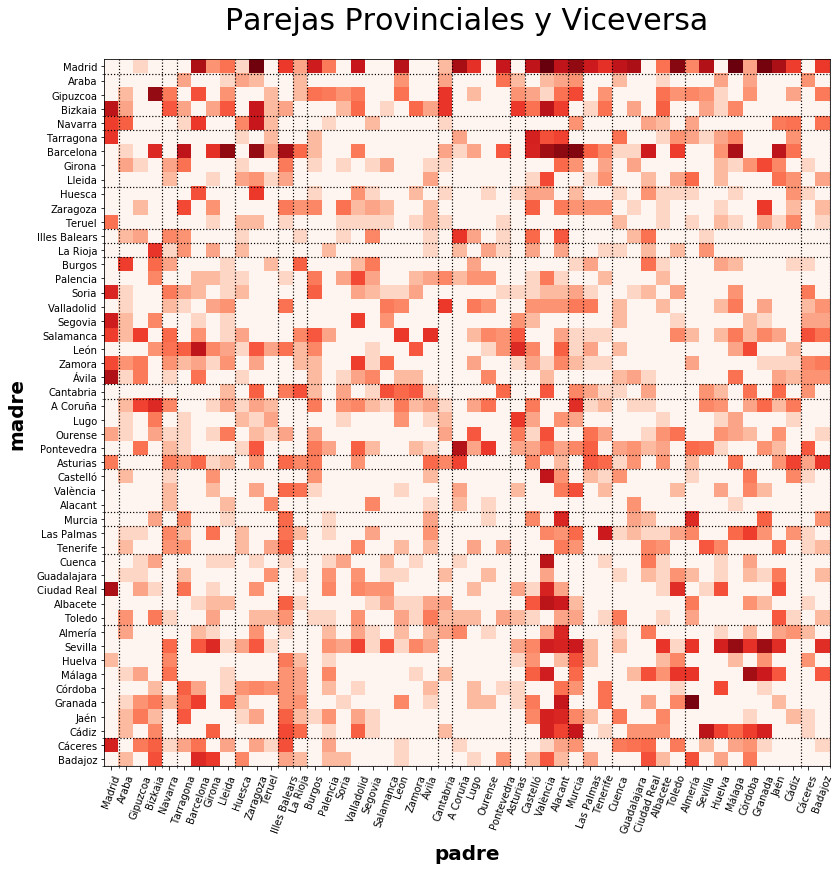

In [103]:
plot_matriz(matriz_sexo_diferencial, 'Parejas Provinciales y Viceversa', True)

En esta matriz la intensidad del color rojo indica que esa pareja es más frecuente que su recíproca. Por ejemplo, vemos que en general son más frecuentes las parejas reproductivas de Madrileñas con gente de otras provincias que de Madrileños con gente de otras provincias. Asímismo, vemos que en general los Valencianos tienen más éxito con las Andaluzas que las Valencianas con los Andaluces.

In [105]:
matriz_sexo_diferencial = matrices[año].copy()
n = matrices[año].shape[0]
minimo_significativo = 20
for i in range(0,n):
    for j in range(0,n):
        if matrices[año].iloc[i,j] > minimo_significativo and matrices[año].iloc[j,i] > minimo_significativo:
            matriz_sexo_diferencial.iloc[i,j] = max(matrices[año].iloc[j,i] / matrices[año].iloc[i,j], 1)
        else:
            matriz_sexo_diferencial.iloc[i,j] = 1

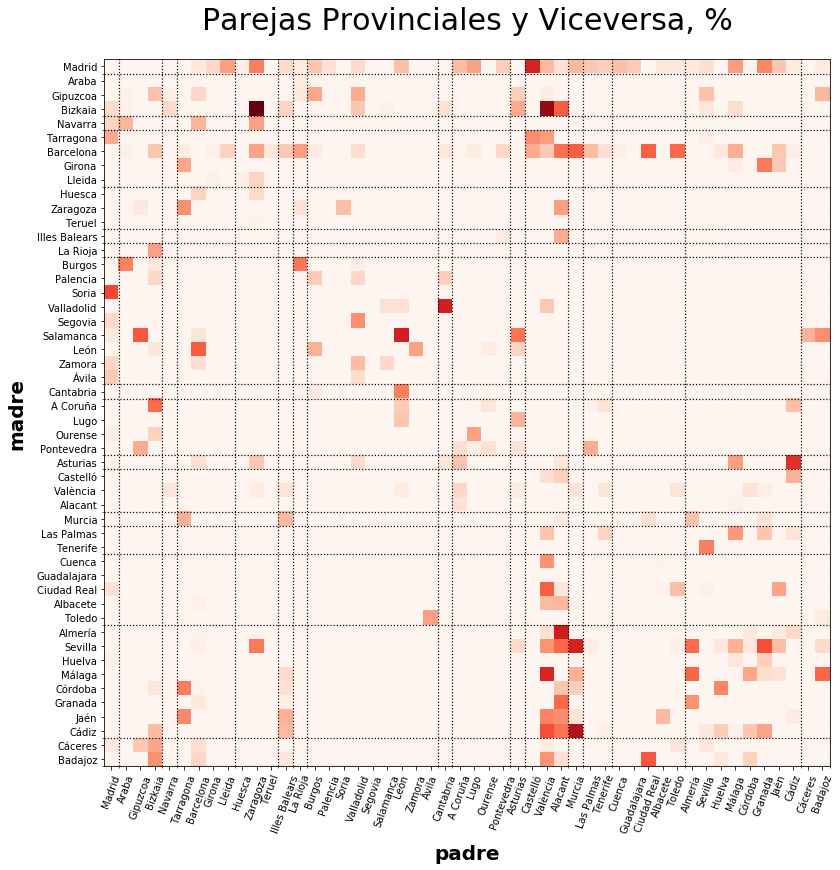

In [106]:
plot_matriz(matriz_sexo_diferencial, 'Parejas Provinciales y Viceversa, %', True)

Esta matriz es equivalente a la anterior, solo que la frecuencia de una pareja reproductiva respecto a su recíproca provincial se expresa en términos porcentuales, por lo que ahora podemos comparar estas anomalías entre diferentes provincias sin importarnos el peso poblacional de cada una

In [107]:
top_matriz(matriz_sexo_diferencial, x = 'respecto a viceversa', funcion_values = 'delta%')

,madre,padre,respecto a viceversa
1º,Bizkaia,Zaragoza,+ 100.0 %
2º,Bizkaia,València,+ 89.19 %
3º,Cádiz,Murcia,+ 79.41 %
4º,Almería,Alacant,+ 68.97 %
5º,Salamanca,León,+ 68.18 %
6º,Valladolid,Cantabria,+ 68.18 %
7º,Sevilla,Murcia,+ 67.57 %
8º,Madrid,Castelló,+ 66.67 %
9º,Málaga,València,+ 65.71 %
10º,Asturias,Cádiz,+ 61.9 %


En este ranking vemos que, curiosamente, las dos mayores desviaciones las protagonizan las Vizcaínas. Hay el doble de Vizcaínas teniendo hijos con Zaragozanos que al revés, y con Valencianos, un 90% más.

In [108]:
top_matriz(matriz_sexo_diferencial, top = 3, x = 'respecto a viceversa', madres = 'Ourense', funcion_values = 'delta%')

,madre,padre,respecto a viceversa
1º,Ourense,Lugo,+ 28.57 %
2º,Ourense,Bizkaia,+ 14.29 %
3º,Ourense,Madrid,+ 4.76 %


Analizando el caso de Ourense, vemos a donde han podido ir a buscar parejas reproductivas algunos de esos Vizcaínos que han visto a sus mujeres irse con Zaragozanos y Valencianos.

In [109]:
top_matriz(matriz_sexo_diferencial, top = 3, x = 'respecto a viceversa', padres = 'Ourense', funcion_values = 'delta%')

,madre,padre,respecto a viceversa
1º,Pontevedra,Ourense,+ 9.74 %
2º,A Coruña,Ourense,+ 7.61 %
3º,León,Ourense,+ 4.55 %


<a name="fidelidad"></a> 

<div style="text-align:justify"><span style="color:blue; font-family:Georgia; font-size:2em;">[IV] Fidelidad Provincial</span></div>

### Normalización Matriz por Pareja

In [31]:
matrices_pareja_normal = {}

for key in list(DFs.keys()):
    
    # normalizar matriz por pareja
    matrices_pareja_normal[key] = matrices[key].astype('float64')
    for i in matrices[key].index:
        total_mujeres = matrices[key].loc[i,:].sum()
        for j in matrices[key].columns:
            total_hombres = matrices[key].loc[:,j].sum()
            matrices_pareja_normal[key].loc[i,j] = matrices[key].loc[i,j]/(total_mujeres+total_hombres - matrices[key].loc[i,j])

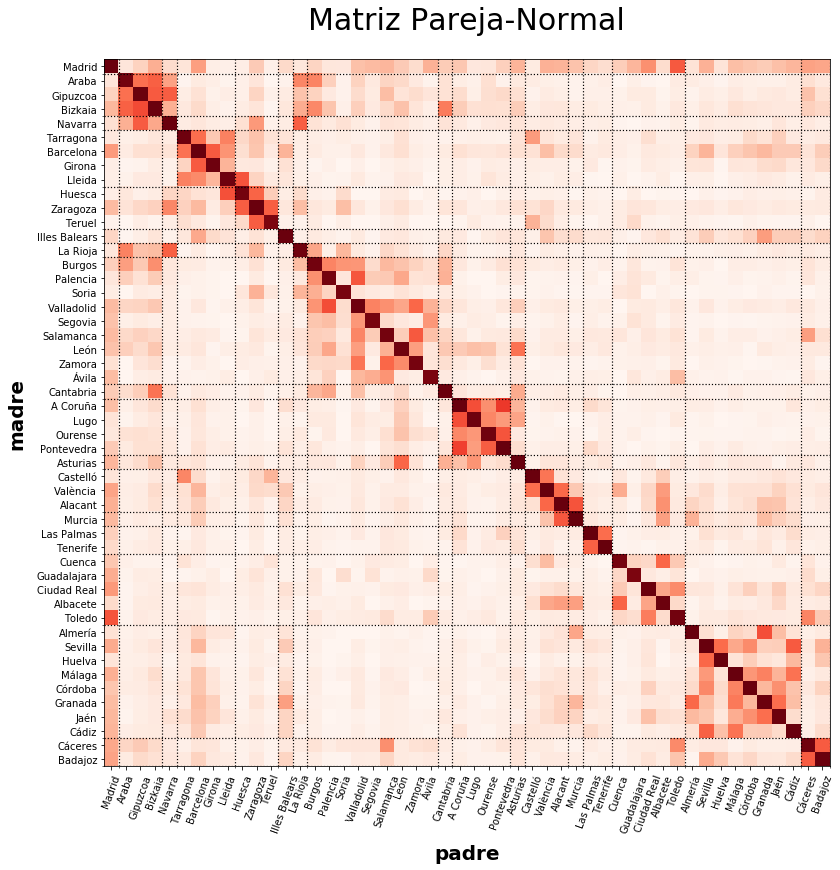

In [96]:
plot_matriz(matrices_pareja_normal[año], 'Matriz Pareja-Normal', True, 100, False)

In [33]:
def get_diagonal(matriz, ordenar = True):
    diagonal = []
    for i in range(0,matriz.shape[0]):
        diagonal.append(matriz.iloc[i,i])
    diagonal = pandas.Series(diagonal,list(matriz.index))
    if ordenar == True:
        diagonal = diagonal.sort_values(ascending = False)
    return(diagonal)

In [40]:
def top_serie(serie, top = 10, que = 'max', x = 'values', funcion_values = lambda x : round(x, 2)):
    df = pandas.DataFrame({'Provincia': serie.index , x: serie}).sort_values([x], ascending = (que == 'min'))
    df.index = [str(i + 1) + 'º' for i in df.reset_index().index]
    if isinstance(funcion_values, str):
        if funcion_values == 'delta%':
            funcion_values = lambda x : '+ ' + str(round((x-1)*100,2)) + ' %'
        elif funcion_values == 'delta':
            funcion_values = lambda x : '+ ' + str(round(x,2))
        elif funcion_values == '%':
            funcion_values = lambda x : str(round(x*100,2)) + ' %'
    df[x] = df[x].apply(funcion_values)
    return(df.head(top))

In [41]:
fidelidad = get_diagonal(matrices_pareja_normal[año])
top_serie(fidelidad, x = 'Fidelidad', funcion_values = '%')

,Provincia,Fidelidad
1º,Tenerife,71.65 %
2º,Las Palmas,69.28 %
3º,Murcia,65.89 %
4º,València,64.64 %
5º,Barcelona,63.38 %
6º,Sevilla,62.81 %
7º,Cádiz,60.88 %
8º,Pontevedra,60.77 %
9º,Málaga,59.64 %
10º,Huelva,59.45 %


In [94]:
def plot_mapa(serie, titulo = ' ', suavizado_logarítmico = False, times_sl = 1 ):
    if suavizado_logarítmico == True:
        for time in range(0,times_sl):
            serie = serie.apply(lambda celda : math.log(max(0,celda) + 1) )    
    serie.name = titulo
    mapa = map_df.join(serie)
    mapa.loc[mapa[titulo].isnull(),titulo]  = 0
    mapa = mapa[mapa["CCAA"] != "Canarias"]
    
    fig, ax = plt.subplots(1,1, figsize=(20, 20), squeeze =True)
    eq = 'equal_interval'
    mapa.plot(column=titulo,cmap=colormap,linewidth=1.8,ax=ax,categorical=True,k=10,edgecolor='0.2', scheme= eq, legend=True)
    ax.set_title(titulo, fontdict = {'fontsize': 30,'fontweight':700}, pad =30)
    ax.axis('off')

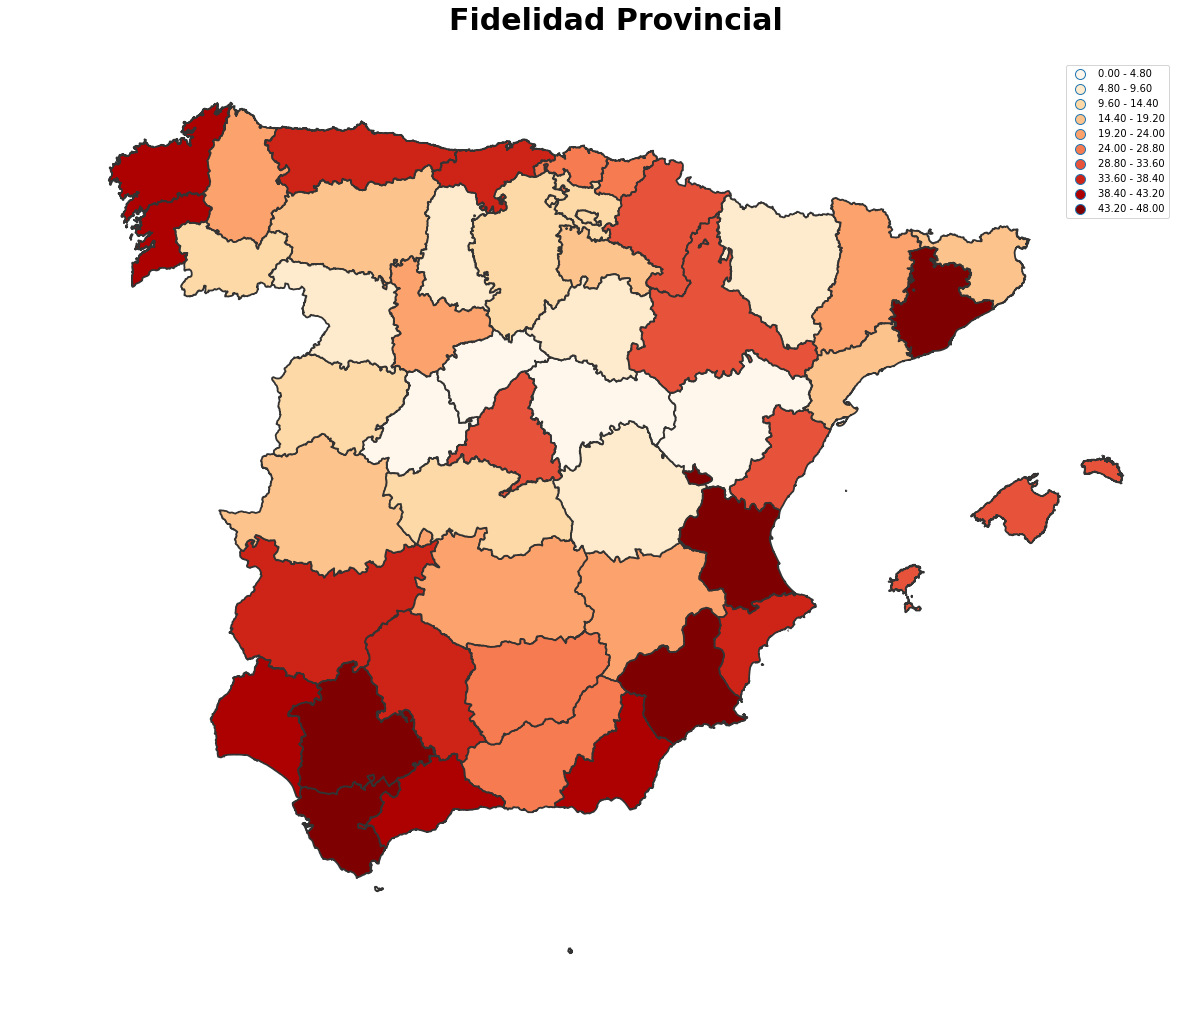

In [95]:
plot_mapa(fidelidad, 'Fidelidad Provincial')

En este mapa representamos el porcentaje de personas que tienen hijos con gente de su misma provincia